# Milestone 2

- Name : Rahmat Fadhli Syauqi
- Batch : FTDS011

URL Apps : https://cvd-xray.herokuapp.com/


## I. Introduction

This project is meant for fulfilling Hacktiv8 Fulltime Datascience Bootcamp Milestone-2 Phase 2 assignment.

In this project, I will try to create convolutional neural network in image classification model using algorithm that is available in Tensorflow library and with Keras.

**I.2 Dataset Description**

This dataset contains image of X-ray from Covid-19 image dataset. Some the data will be treating this as a categorical classification problem, where we will attempy to create a model that predicts a patients who infected covid-19 despites from chest X-ray images.

And the dataset we collected from Kaggle "https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset".

**I.4 Objectives**

From this project i will focus to predict the covid-19 patients from chest X-ray images using convolutional neural network in image classification using `Tensorflow` library and `Keras`. From this data we will classify x-ray who get infected from covid-19, normal and Pneumonia.


---
# II. Import Libraries

In [1]:
# Import Libraries
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Model
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten

# Metric
from sklearn.metrics import classification_report

# Inference and Evaluation
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims
import requests
from PIL import Image


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Enable Mixed Precision training for faster process (NVIDIA GPU Only)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


---
# III. Data Loading

In [3]:

os.listdir('D:\HackTiv8\learning_journal\learning_journal\phase_2\week_2\ML2\COVID-19')

['inf_set', 'test', 'train']

In [4]:
# Created a path for dataset
main_path= 'D:\HackTiv8\learning_journal\learning_journal\phase_2\week_2\ML2\COVID-19'
train_dir= os.path.join(main_path, 'train') # Path for train
test_dir = os.path.join(main_path, 'test') # Path for test
inf_dir = os.path.join(main_path, 'inf_set') # Path for Inference

In [5]:
# Confirmation path to value
num_covid= len(os.listdir(os.path.join(train_dir, 'Covid'))) 
num_pneumonia= len(os.listdir(os.path.join(train_dir, 'Viral Pneumonia'))) 
num_normal= len(os.listdir(os.path.join(train_dir, 'Normal')))

print(num_covid)
print(num_pneumonia)
print(num_normal)



111
70
70


In [6]:
# Create a variable from filepaths
train_normal= glob.glob(train_dir + '/Normal/*.jpeg')
train_pneumonia= glob.glob(train_dir + '/Viral Pneumonia/*.jpeg')
train_covid= glob.glob(train_dir + '/Covid/*.jpeg')

test_normal= glob.glob(test_dir + '/Normal/*.jpeg')
test_pneumonia= glob.glob(test_dir + '/Viral Pneumonia/*.jpeg')
test_covid= glob.glob(test_dir + '/Covid/*.jpeg')

In [7]:
# Creating data
def create_dataframe(list_of_images):
  data=[]
  for image in list_of_images:
    data.append((image, image.split('/')[-1].split('\\')[0]))

  return pd.DataFrame(data, columns= ['images', 'label'])

train_df= create_dataframe(train_normal + train_pneumonia + train_covid)
train_df= train_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_df= create_dataframe(test_normal + test_pneumonia + test_covid)
test_df= test_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
# Show shape of sampe from train set
print(train_df.shape)
train_df

(186, 2)


,images,label
0,D:\HackTiv8\learning_journal\learning_journal\...,Viral Pneumonia
1,D:\HackTiv8\learning_journal\learning_journal\...,Covid
2,D:\HackTiv8\learning_journal\learning_journal\...,Covid
3,D:\HackTiv8\learning_journal\learning_journal\...,Viral Pneumonia
4,D:\HackTiv8\learning_journal\learning_journal\...,Viral Pneumonia
...,...,...
181,D:\HackTiv8\learning_journal\learning_journal\...,Viral Pneumonia
182,D:\HackTiv8\learning_journal\learning_journal\...,Normal
183,D:\HackTiv8\learning_journal\learning_journal\...,Viral Pneumonia
184,D:\HackTiv8\learning_journal\learning_journal\...,Covid


---
# IV. Exploratory Data Analysis

First of all we need to check the distribution of our classes label, its imbalanced or not?

In [11]:
# Distribution Check
categoricals = ['label']
for i in categoricals:
    print(i)
    print(train_df[i].value_counts())
    print()





label
Viral Pneumonia    70
Normal             70
Covid              46
Name: label, dtype: int64



Text(0.5, 1.0, 'label')

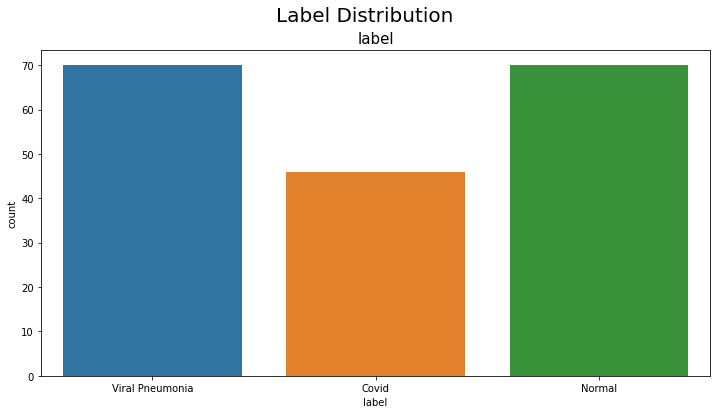

In [14]:
# Label Distribution Visualization
fig, ax = plt.subplots(ncols=1, figsize=(12,6))
plt.suptitle('Label Distribution', fontsize=20)
sns.countplot(x='label', data=train_df, palette='tab10')
ax.set_title('label', fontsize=15)

From the labels distribution insight that we get above, as we can see there are same value between class Pneumonia and Normal, however class Covid has small data than the others but there still is little balance for this dataset.

So, let's take a look inside of the data in classes.

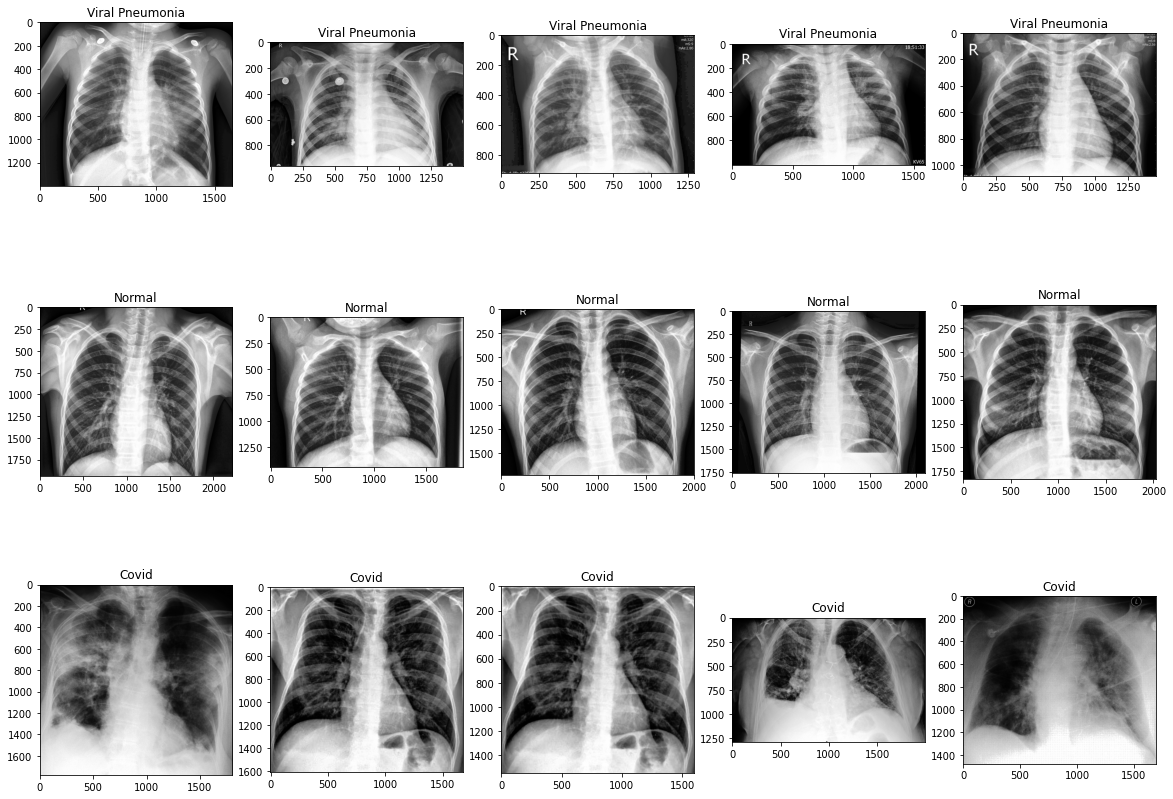

In [9]:
# Plot the picture with labels
pneumonia_samples= (train_df[train_df['label']=='Viral Pneumonia']['images'].iloc[:5]).tolist()
normal_samples= (train_df[train_df['label']=='Normal']['images'].iloc[:5]).tolist()
covid_samples= (train_df[train_df['label']=='Covid']['images'].iloc[:5]).tolist()

# Function visualize sample image
def visualize_samples(samples):
  fig,ax= plt.subplots(nrows=3, ncols=5, figsize= (20,15))
  for i, sample in enumerate(samples):
    img= cv2.imread(sample)
    ax[i//5, i%5].set_title(sample.split('/')[-1].split('\\')[0])
    ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
# Execute the function
visualize_samples(pneumonia_samples + normal_samples + covid_samples)

**Insight of Class :**

1. Viral Pneumonia : Common radiographic features in viral pneumonia include bilateral patchy consolidation, lobar consolidation, diffuse areas of air space consolidation or interstitial lung disease.
2. Normal : Hollow structures containing mostly air, such as the lungs, normally appear dark. In a normal chest X-ray, the chest cavity is outlined on each side by the white bone structures that represent the ribs of the chest wall. On the top portion of the chest are the neck and the collar bones (clavicles) (emedicinehealt.com).
3. Covid : Covid-19 affect lungs organs and also have a wide impack to organs, the most commong sickness are cough, shortness of breath, fever and sore throat.

---
# V. Data Preprocessing

In this process I split my dataset into train, test, and validation set

**Dataset Splitting**

In this process, I will split my dataset into different set:

- Use 80% from dataset for Train Set
- Use 20% from dataset for Validation Set

all of those entries will be randomly selected from the dataset.

In [8]:
# Set random state 
np.random.seed(42)
tf.random.set_seed(42)
random_state = 42

In [9]:
# Splitting Dataset

# Train Set & Val Set
train_images, val_images = train_test_split(train_df, test_size=0.2, random_state=random_state)

In [10]:
# Size Summary

print('Train Set shape : ', train_images.shape)
print('Val Set shape : ', val_images.shape)
print('Test Set shape : ', test_df.shape)

Train Set shape :  (148, 2)
Val Set shape :  (38, 2)
Test Set shape :  (45, 2)


In [11]:
# Make copy from the test_df
test_image = test_df.copy()

**Preprocessing Model**



In [12]:
# Preset image data generator
type_gen_1= ImageDataGenerator(
    rescale= 1./255, #Scaling size data
    brightness_range = (0.5,1.5), #Change brightness of image
    #rotation_range= 0.2,
    #width_shift_range= 0.2,
    #shear_range= 0.2,
    #zoom_range= 0.2,
    horizontal_flip= True,
    dtype = 'float32')

type_gen_2= ImageDataGenerator(rescale= 1./255,
                                dtype = 'float32')





ImageDataGenerator information:
- rescale the image pixel values 
- brightness range for data images s 0.5 and 1.5.
- horizontal flip for augmentation image since the data image just x-ray image.

In [13]:
# Setting up the model variables
img_height= 220 # Height of image
img_width= 220 # Width of image
SEED= 1
BATCH= 32 # Standar batch size to process model

In [14]:
# Tensorflow pipeline

train= type_gen_1.flow_from_dataframe(dataframe= train_images,
                                            x_col= 'images',
                                            y_col= 'label',
                                            target_size= (img_height,img_width),
                                            class_mode= 'sparse',
                                            batch_size= BATCH,
                                            shuffle= True,
                                            seed= SEED
                                         )

val= type_gen_2.flow_from_dataframe(dataframe= val_images,
                                        x_col= 'images',
                                        y_col= 'label',
                                        target_size= (img_height,img_width),
                                        class_mode= 'sparse', # We have multiple class consist (Pneumonia, Normal, Covid)
                                        batch_size= BATCH,
                                        shuffle= False,
                                        seed= SEED
                                      )

test= type_gen_2.flow_from_dataframe(dataframe= test_image,
                                        x_col= 'images',
                                        y_col= 'label',
                                        target_size= (img_height,img_width),
                                        class_mode= 'sparse',
                                        batch_size= BATCH,
                                        shuffle= False,
                                        seed= SEED
                                       )

Found 148 validated image filenames belonging to 3 classes.
Found 38 validated image filenames belonging to 3 classes.
Found 45 validated image filenames belonging to 3 classes.


Flow dataframe information :

1. Target size : The size of the target image 220x220 because it will be the most size for our model to predict.
2. Class Mode : The class mode is categorical because we will use sparse categorical classification consist of (Normal, Pneumonia, Covid-19).
3. Batch size : we use 32 because we just have small data and we dont need process run faster 


In [15]:
# key_value for labels multiclas
key_value = train.class_indices
key_value

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [16]:
class_names = list(train.class_indices.keys())
print(class_names)

['Covid', 'Normal', 'Viral Pneumonia']


Text(0.5, 1.0, 'Original')

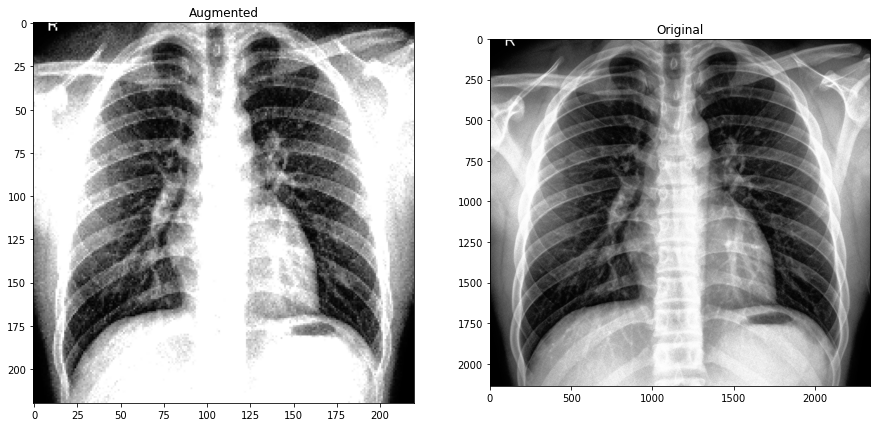

In [17]:
# Show augmented images
images, labels  = next(train)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax[0].imshow(images[0])
ax[0].set_title('Augmented')
original = plt.imread(train.filepaths[train.index_array[BATCH*(train.batch_index-1)]])
ax[1].imshow(original)
ax[1].set_title('Original')

The augmented image was a technique to altering from existing data for model training process, and we need to check dataset for training deep learning model

From this result above, because our image data was X-ray image, we will use the ImageDataGenerator to preprocess the data for result Data Augmentation. after we trial & error to some parameter, after all we just use brightness range and horizontal flip to our image and the images already black & white.

---
# VI. Model Definition

On this section we will define base models for each convolutional neural network architecture that will be used. We will use the following architecture is Sequential Method

**Sequential Base Model**


In [40]:
# Sequential API Method

# Input shape
input= [img_height,img_width,3]

# Model Process
model_base = Sequential()
# Convolutional 1
model_base.add(Conv2D(filters=8, kernel_size=3, activation= 'relu', padding='same', input_shape= input))
model_base.add(MaxPooling2D(pool_size=2, strides=2))

# Convolutional 2
model_base.add(Conv2D(filters=16,kernel_size=3, activation='relu', padding='same'))
model_base.add(MaxPooling2D(pool_size=2, strides=2))

# Convolutional 3
model_base.add(Conv2D(filters=32,kernel_size=3, activation='relu', padding='same'))
model_base.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten layer 
model_base.add(Flatten())

# Fully Connected Layer
model_base.add(Dense(64, activation='relu'))

# Output l
model_base.add(Dense(3, activation='softmax')) # Contains 3 class (Multiclass)

# Compile Model
model_base.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])


#Summary
model_base.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 220, 220, 8)       224       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 110, 110, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 110, 110, 16)      1168      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 55, 55, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 55, 55, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 27, 27, 32)      

Model base information :

- Method : i use Sequential method as a my base model architecture
- MaxPooling2D : using pool size 2 to take maximum from max value over 2x2 pooling, and using 2 strides to take specific window moves for each pooling step.
- Using 3 convolutional layers with 3x3 kernel size, and using relu activation function because we want to use this based popularity for start base model
- Using softmax as my output activation because our data has 3 classes
- Model compile consist of Adam as my optimizer , Sparse Categorical Crossentropy due my target label is multiclass, and set metrics to 'accuracy'


In [41]:
# Funtion for callback with early_stopping

# class stop_training(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if (logs.get('val_accuracy')>0.80):
#             print("\nReached 80% accuracy so canceling training!")
#             self.model.stop_training = True

# my_callbacks = stop_training()


callbacks= [
            EarlyStopping(monitor= 'val_loss', mode='min', patience= 5, verbose=1),
            ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only= True)
]

In this part i set function for callbacks, early_stopping and ModelCheckpoint because we need efficiency time for training model. In processing image we might take a long time to process and will stop when val_loss is not improving. i try to use patience 5 for better result efficient. 

---
# VII. Model Training

This part take baseline model and further will be improved with Model Improvement

In this training processing image model, i set epoch on 50 as limitation. and i've tried to use batch size 32 , the process will be stop before limit epoch because i set up Earlystoping callback.

In [42]:
# Train Sequential base model Method
history_base= model_base.fit(train, batch_size= BATCH, epochs= 50,
                         validation_data= val, callbacks= callbacks, verbose=1)

Epoch 1/50
5/5 [==============================] - 41s 8s/step - loss: 0.9680 - accuracy: 0.5135 - val_loss: 0.8377 - val_accuracy: 0.5263
Epoch 2/50
5/5 [==============================] - 41s 8s/step - loss: 0.7875 - accuracy: 0.6622 - val_loss: 0.8644 - val_accuracy: 0.4737
Epoch 3/50
5/5 [==============================] - 36s 7s/step - loss: 0.5509 - accuracy: 0.7973 - val_loss: 0.3276 - val_accuracy: 0.9474
Epoch 4/50
5/5 [==============================] - 35s 7s/step - loss: 0.3238 - accuracy: 0.8581 - val_loss: 0.1814 - val_accuracy: 0.9737
Epoch 5/50
5/5 [==============================] - 36s 7s/step - loss: 0.2573 - accuracy: 0.9189 - val_loss: 0.1090 - val_accuracy: 0.9737
Epoch 6/50
5/5 [==============================] - 35s 8s/step - loss: 0.2100 - accuracy: 0.9189 - val_loss: 0.1650 - val_accuracy: 0.9211
Epoch 7/50
5/5 [==============================] - 35s 8s/step - loss: 0.1960 - accuracy: 0.9189 - val_loss: 0.0746 - val_accuracy: 1.0000
Epoch 8/50
5/5 [==================

---
# VIII. Model Evaluation
In this part of process, I will try to evaluate the trained model and make conclusion out of it.

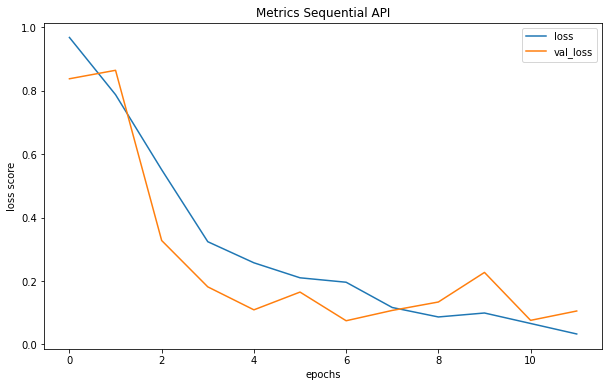

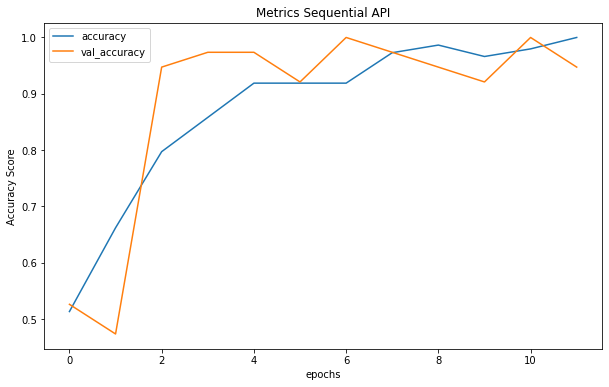

In [43]:
# Evaluation of Base Model

metrics_base = pd.DataFrame(history_base.history)

# Visualization Sequential
metrics_base[['loss','val_loss']].plot(figsize=(10, 6))
plt.title('Metrics Sequential API')
plt.ylabel('loss score')
plt.xlabel('epochs')
plt.show()

# Visualization Sequential
metrics_base[['accuracy','val_accuracy']].plot(figsize=(10, 6))
plt.title('Metrics Sequential API')
plt.ylabel('Accuracy Score')
plt.xlabel('epochs')
plt.show()

As we can see from our base model, we have the result very bad val_accuracy and val_loss get exploded because of the data that we have. However the train line get smooth  or enough stable performance, cause we have some almost good fitting and little exploded performance on early epoch, we need to make our model more accuracte and stable for validation result with adding some parameters that we will try to use.

From the graph above as we figure our model can be read and we can conclude this model has good performance/ good fitting.

In [44]:
# Clasification Report from Base model

# label data
label_data = list(test.class_indices.keys())

y_pred = model_base.predict(test)
y_pred = np.argmax(y_pred, axis = 1)

report_base = classification_report(test.labels,
                                    y_pred,
                                    labels = np.arange(3),
                                    target_names = label_data)

print(report_base)


2/2 [==============================] - 1s 196ms/step
                 precision    recall  f1-score   support

          Covid       1.00      0.82      0.90        11
         Normal       0.94      0.88      0.91        17
Viral Pneumonia       0.80      0.94      0.86        17

       accuracy                           0.89        45
      macro avg       0.91      0.88      0.89        45
   weighted avg       0.90      0.89      0.89        45



Based on classification report, our model perform very well for predicting all classes, and has the result with average 82-88% on recall for class 'Covid' & 'Normal' and 94% for class Viral Pneumonia. and has accuracy for 89%. We got good result because we have balance data for training our model.

## Model Improvement

In this sub-section we will try improve the model by adding more layers and add parameters that will reduce val_loss and increase accuracy.

**Model Improvement 1**

In this model improvement we will changing some parameters that will make our model has stable performance and improve accuracy and reduce loss value.

so we need to plan our architecture model improvement, and the information here:
- Add some parameters to reduce overfitting and decline exploding

In [47]:
# Sequential Improvement Method

# Input shape
input= [img_height,img_width,3]

# Model Process
model_imp = Sequential()
# Convolutional 1
model_imp.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', padding='same', input_shape= input))
model_imp.add(MaxPooling2D(pool_size=2, strides=2))

# Convolutional 2
model_imp.add(Conv2D(filters=32,kernel_size=3, activation='relu', padding='same'))
model_imp.add(MaxPooling2D(pool_size=2, strides=2))

# Convolutional 3
model_imp.add(Conv2D(filters=64,kernel_size=3, activation='relu', padding='same'))
model_imp.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten layer 
model_imp.add(Flatten())

# Fully Connected Layer
model_imp.add(Dense(128, activation='relu'))
#model_imp.add(Dense(64, activation='relu'))
#model_imp.add(Dense(32, activation='relu'))
#model_imp.add(Dropout(0.2)) #Will dropping 20% of the output from applied layer

# Output l
model_imp.add(Dense(3, activation='softmax')) # Contains 3 class (Multiclass)

# Compile Model
model_imp.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adamax',
              metrics=['accuracy'])


#Summary
model_imp.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 110, 110, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 55, 55, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 27, 27, 64)      

Some change that i try to use for this model improvement:

- Create 3 convolutional layers
-  Change optimizer into Adamax because it more superior than Adam
- Add 2 layers on fully connected layers
- Add ReLU as our activator model rather than tanh, because it more stable and more efficient and sensitive to the x-ray image data.


In [48]:
# Set Callback for Improvements model
callbacks_imp= [
            # Checkpoint for every best metrics to be save model
            EarlyStopping(monitor= 'val_loss', mode='min', patience= 5, verbose=1),
            # Stop training when val_loss get lower within patience value
            ModelCheckpoint('model_imp.hdf5', monitor='val_loss', save_best_only= True)
]

In [49]:
# Train Improvement model Method
history_imp= model_imp.fit(train, batch_size= 128, epochs= 50, steps_per_epoch= 3,
                         validation_data= val, callbacks= callbacks_imp, verbose=1)

Epoch 1/50
3/3 [==============================] - 81s 26s/step - loss: 1.6990 - accuracy: 0.4405 - val_loss: 2.4232 - val_accuracy: 0.3421
Epoch 2/50
3/3 [==============================] - 86s 29s/step - loss: 1.3883 - accuracy: 0.3958 - val_loss: 1.0208 - val_accuracy: 0.5526
Epoch 3/50
3/3 [==============================] - 74s 24s/step - loss: 0.9953 - accuracy: 0.5476 - val_loss: 1.0144 - val_accuracy: 0.4474
Epoch 4/50
3/3 [==============================] - 85s 28s/step - loss: 0.9743 - accuracy: 0.6354 - val_loss: 0.9795 - val_accuracy: 0.5526
Epoch 5/50
3/3 [==============================] - 78s 25s/step - loss: 0.9378 - accuracy: 0.6786 - val_loss: 0.9208 - val_accuracy: 0.6316
Epoch 6/50
3/3 [==============================] - 87s 29s/step - loss: 0.8327 - accuracy: 0.6875 - val_loss: 0.8779 - val_accuracy: 0.6053
Epoch 7/50
3/3 [==============================] - 85s 28s/step - loss: 0.7104 - accuracy: 0.6979 - val_loss: 0.8071 - val_accuracy: 0.6053
Epoch 8/50
3/3 [===========

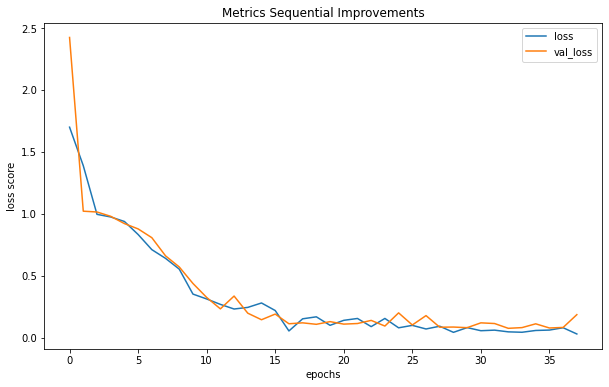

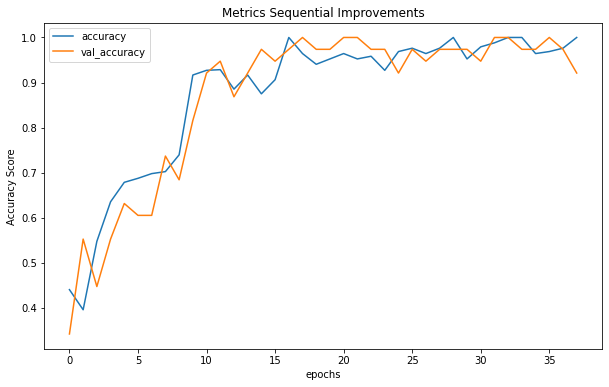

In [50]:
# Evaluation of Sequential Improved Model

metrics_imp = pd.DataFrame(history_imp.history)

# Visualization Sequential Improvements
metrics_imp[['loss','val_loss']].plot(figsize=(10, 6))
plt.title('Metrics Sequential Improvements')
plt.ylabel('loss score')
plt.xlabel('epochs')
plt.show()

# Visualization Sequential Improvements
metrics_imp[['accuracy','val_accuracy']].plot(figsize=(10, 6))
plt.title('Metrics Sequential Improvements')
plt.ylabel('Accuracy Score')
plt.xlabel('epochs')
plt.show()

From the result om Model improvements, we get better result on accuracy and loss value., we success make the validation almost get stable performance with 90% accuracy and 15% loss score on validation data, after all we get this model after a long time trial and error. Before that we used only 2 convolutional layers but there are not has good performance to our model.

On loss score graph and accuracy got converge when epoch 8, after reach epoch 17 the model get stable performance with accuracy and loss value. We get this better result when we used 1 fully connected layers with 128 neurons, if we have so much time to train our model, we can get better result if we use 512 neuron on fully connected layer.

In [51]:
# Clasification Report from Model Improvements

# label data
label_data = list(test.class_indices.keys())

y_pred_imp = model_imp.predict(test)
y_pred_imp = np.argmax(y_pred_imp, axis = 1)

report_imp = classification_report(test.labels,
                                    y_pred_imp,
                                    labels = np.arange(3),
                                    target_names = label_data)

print(report_imp)

2/2 [==============================] - 2s 388ms/step
                 precision    recall  f1-score   support

          Covid       1.00      0.82      0.90        11
         Normal       0.94      0.94      0.94        17
Viral Pneumonia       0.84      0.94      0.89        17

       accuracy                           0.91        45
      macro avg       0.93      0.90      0.91        45
   weighted avg       0.92      0.91      0.91        45



From the classification report that we get, we can conclude out model has better result from base model, which is our Model improvement has good predict on class 'Normal' with 94% recall and 94% f1-score with 91% accuracy as before from our base model, if we want to make our model better than this we can add more layers deeply to make our model has better performance. We got perfect score on precision on Class Covid eventho has the lowest recall score than other class, but we still use this model for prediction.

So, i decided to choose Sequential API Improved model as my final model.


---
# IX. Model Saving

In this part of sub-process, I will save the chosen model so that it can be deployed to the production environment.

In [ ]:
# Save the best model
model_imp.save('model_imp_final.h5')

---
# X. Model Inference

In this part of process, I will try to feed the convolutional neural network model using the Inference Set and see how it perform.

First of all we need to load our best improved model to predict image outside from database that i already prepared it before.

**First way to predict**

In [18]:
# Load Model
model = load_model('model_imp_final.h5')

In [20]:
# Prepare data for prediction

inf1 = r'ML2\COVID-19\inf_set\Covid\covid - 1.jpeg'
inf2 = r'ML2\COVID-19\inf_set\Covid\covid - 2.jpeg'
inf3 = r'ML2\COVID-19\inf_set\Normal\Normal - 1.jpeg'
inf4 = r'ML2\COVID-19\inf_set\Normal\Normal - 2.jpeg'
inf5 = r'ML2\COVID-19\inf_set\Viral Pneumonia\Pneumonia - 1.jpeg'
inf6 = r'ML2\COVID-19\inf_set\Viral Pneumonia\Pneumonia - 3.jpeg'




In [22]:
# Prepare inference set for predict
predictions = []
for i in (inf1, inf2, inf3, inf4, inf5, inf6):
    img = (keras.preprocessing.image.load_img(i, target_size=(img_height, img_width)))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

# Predict Result
    pred = model.predict(img_array)
    predictions.append (pred)


    print(
        "Our model predict this image is {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(pred)], 100 * np.max(pred))
    )

1/1 [==============================] - 0s 181ms/step
Our model predict this image is Covid with a 100.00 percent confidence.
1/1 [==============================] - 0s 127ms/step
Our model predict this image is Covid with a 100.00 percent confidence.
1/1 [==============================] - 0s 119ms/step
Our model predict this image is Normal with a 100.00 percent confidence.
1/1 [==============================] - 0s 120ms/step
Our model predict this image is Normal with a 100.00 percent confidence.
1/1 [==============================] - 0s 130ms/step
Our model predict this image is Viral Pneumonia with a 100.00 percent confidence.
1/1 [==============================] - 0s 116ms/step
Our model predict this image is Viral Pneumonia with a 100.00 percent confidence.


**Inference Summary :**

Based on result above from inference set, we got our model successfully predict chest x-ray images that contains Covid-19, Pneumonia, and Normal.

---
# XI. Conclusion
Here all the conclusion that I get from this project

**EDA Analysis**

1. Our project has 3 classes which is Viral Pneumonia, Normal & Covid which has balanced data.
2. All dataset has different sizes so we take a resize first to train data get better result.
3. Our data images is chest x-ray images, so we take preprocessing which only re-scalling size data, setting up brightness range and horizontal flip.


**Model Analysis**

- Our base model using Sequential API with 3 convolutional layers and 1 fully connected layers, we use ReLU as our activation and softmax as output activation because we have multiclass labels, the optimizer using Adam because the most used for base model. However we got quite good result and not good fitting but we got 89% accuracy and get 94% recall on Pneumonia class.
- On our Model Improvement we try train and error for add layers and add some parameters that we need to reduce overfitting and decrease loss value. First of all we try with 3 convolutional layers and ad 3 Dense layers but we got bad result and exploded graph on loss value and accuracy, then we try to used only 1 fully connected layer with 128 neuron and using Adamax as our optimizer  and we got very better result than our base mode with 91% accuracy and average recall in 90% annd 91% f1-score. 9% accuracy that we dont get it maube cause of no complexity and deep layer from our architecture model, however we tried to make a simple but effective model to get our result better score.
- Insight of our model from datasets, Normal x-ray images get better prediction because this data get very variative and less noise within images.



---
**Refrences**

- `https://stackoverflow.com/questions/71493889/how-can-reslove-invalidargumenterror-graph-execution-error
https://www.dovepress.com/`

- `machine-learning-model-applied-on-chest-x-ray-images-enables-automatic-peer-reviewed-fulltext-article-IJGM`